In [11]:
import torch
import numpy as np
from diffusion_co_design.rware.diffusion.generate import generate
from diffusion_co_design.rware.diffusion.transform import (
    storage_to_layout_image,
    graph_projection_constraint,
)

from diffusion_co_design.rware.schema import ScenarioConfig as RwareScenarioConfig
from matplotlib import pyplot as plt
from rware.warehouse import Warehouse
from wfcrl.environments.data_cases import floris_ormonde
from diffusion_co_design.wfcrl.schema import ScenarioConfig as WfcrlScenarioConfig
from diffusion_co_design.wfcrl.env import _create_designable_windfarm


In [ ]:
shelf_im = generate(size=8, n_shelves=20, goal_idxs=[0, 7, 55, 63], n_colors=4)[0]
layout = storage_to_layout_image(
    shelf_im,
    agent_idxs=[12, 23, 54, 8],
    agent_colors=[-1, -1, -1, -1],
    goal_idxs=[0, 7, 56, 63],
    goal_colors=[0, 1, 2, 3],
)
warehouse = Warehouse(layout=layout)
image = warehouse.render()
image = image[::2, ::2]
warehouse.close()

H, W, C = image.shape

noise = np.random.normal(loc=0.0, scale=1.0, size=image.shape)
noise = (noise - noise.min()) / (noise.max() - noise.min())
noise = noise * 255
noise = noise.astype(np.uint8)

for i, beta in enumerate([0, 0.5, 0.75, 1]):
    blended = ((1 - beta) * image + beta * noise).astype(np.uint8)
    plt.figure(figsize=(12, 6))
    plt.imshow(blended)
    plt.axis("off")
    plt.savefig(f"blended_{i}.png", bbox_inches="tight", dpi=300)

In [ ]:
warehouse = Warehouse(layout=layout)
image = warehouse.render()
warehouse.close()
plt.imshow(image)
plt.axis("off")
plt.savefig("d-rware", bbox_inches="tight", dpi=300)

In [ ]:
scenario = RwareScenarioConfig(
    name="d-rware-example",
    n_agents=3,
    n_shelves=16,
    n_colors=4,
    goal_idxs=[0, 7, 56, 63],
    agent_idxs=[12, 23, 54, 8],
    agent_colors=[-1, -1, -1, -1],
    n_goals=4,
    goal_colors=[0, 1, 2, 3],
    max_steps=100,
    size=8,
)


x0 = []
for x in range(2, 6):
    for y in range(2, 6):
        x0.append((x, y))
x0 = np.array(x0)


def plot_points(layout, scenario: RwareScenarioConfig):
    fig, ax = plt.subplots(1, 1)
    x = [p[0] for p in layout]
    y = [p[1] for p in layout]

    ax.scatter(x, y, s=130, color="blue", edgecolors="black", linewidths=0.5, zorder=3)
    ax.axis("off")

    # Grid lines
    for x in range(scenario.size):
        ax.plot(
            [x, x],
            [0, scenario.size - 1],
            color="gray",
            linewidth=1,
        )

    for y in range(scenario.size):
        ax.plot(
            [0, scenario.size - 1],
            [y, y],
            color="gray",
            linewidth=1,
        )

    ax.set_aspect("equal")
    fig.set_tight_layout(True)
    return fig, ax


# x0
fig, ax = plot_points(x0, scenario=scenario)
fig.savefig("pug_0.png", bbox_inches="tight", dpi=300)

# xT
xT = np.clip(
    (np.random.normal(0, 1.0, size=x0.shape) + 1) / 2 * (scenario.size - 1),
    0,
    (scenario.size - 1),
)
fig, ax = plot_points(xT, scenario=scenario)
fig.savefig("pug_T.png", bbox_inches="tight", dpi=300)

# xt
alpha = 0.7
xt = alpha**0.4 * x0 + (1 - alpha) * xT
fig, ax = plot_points(xt, scenario=scenario)
fig.savefig("pug_t.png", bbox_inches="tight", dpi=300)

# xt_0
xt_0 = x0 + np.random.normal(0, 0.3, size=x0.shape)
fig, ax = plot_points(xt_0, scenario=scenario)
fig.savefig("pug_t0.png", bbox_inches="tight", dpi=300)

# xt constrained
xt_constr = graph_projection_constraint(scenario)(
    torch.tensor(xt_0 / (scenario.size - 1) * 2 - 1, dtype=torch.float32).unsqueeze(0)
)[0].numpy()
xt_constr = (xt_constr + 1) / 2 * (scenario.size - 1)
xt_constr = np.round(xt_constr)
fig, ax = plot_points(xt_constr, scenario=scenario)
fig.savefig("pug_t_constr.png", bbox_inches="tight", dpi=300)

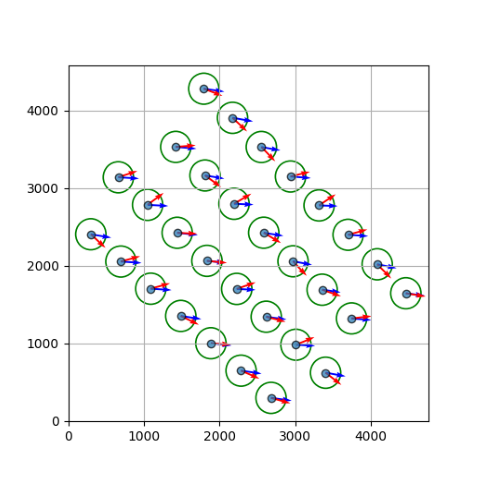

In [64]:
xcoords = np.array(floris_ormonde.xcoords)
ycoords = np.array(floris_ormonde.ycoords)
margin = 300

xcoords = xcoords - xcoords.min() + margin
ycoords = ycoords - ycoords.min() + margin

scenario = WfcrlScenarioConfig(
    name="ormonde_render_example",
    n_turbines=len(xcoords),
    max_steps=margin,
    map_x_length=int(xcoords.max() + margin),
    map_y_length=int(ycoords.max() + margin),
    min_distance_between_turbines=400,
)

env = _create_designable_windfarm(
    scenario=scenario,
    initial_xcoords=xcoords.tolist(),
    initial_ycoords=ycoords.tolist(),
    render=True,
)

# Take some random steps
env.reset()
for _ in range(2000):
    env.step({"yaw": np.array([np.random.rand() * 10 - 5])})

fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")
ax.imshow(env.render(), aspect="auto")

fig.savefig("wfcrl_ormonde.png", bbox_inches="tight", dpi=300)

In [52]:
{agent: env.action_space(agent) for agent in env.agents}

{'turbine_1': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_2': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_3': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_4': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_5': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_6': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_7': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_8': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_9': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_10': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_11': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_12': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_13': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_14': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_15': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_16': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_17': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_18': {'yaw': Box(-5.0, 5.0, (1,), float32)},
 'turbine_19': {'ya